In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
!pip install factor_analyzer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# Методы понижения размерности

## Факторный анализ

#### Загрузка данных

In [4]:
dataset =  pd.read_csv('student-mat.csv')
data = dataset.drop(labels='school', axis=1)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

#### Кодирование

In [6]:
def ordinal_encode(series, categories):
  encoder = OrdinalEncoder(categories=categories, dtype=np.int64)
  return encoder.fit_transform(series.values.reshape(-1, 1))

In [7]:
categories_ordenc = {"sex": [["F", "M"]],
                     "address": [["R", "U"]],
                     "famsize": [["LE3", "GT3"]],
                     "Pstatus": [['A', 'T']],
                     "schoolsup": [["no", "yes"]],
                     "famsup": [["no", "yes"]],
                     "paid": [["no", "yes"]],
                     "activities": [["no", "yes"]],
                     "nursery": [["no", "yes"]],
                     "higher": [["no", "yes"]],
                     "internet": [["no", "yes"]],
                     "romantic": [["no", "yes"]],
                     }

In [8]:
for column, category in categories_ordenc.items():
  data[column] = ordinal_encode(data[column], category)

In [9]:
def onehot_encode(data, column, categories):
  encoder = OneHotEncoder(categories=categories, drop="first", sparse_output=False, dtype=np.int64)
  encoded_features = encoder.fit_transform(data[column].values.reshape(-1, 1))
  encoder.transform(data[column].values.reshape(-1, 1))

  data = data.drop(labels=column, axis=1)

  for j, category in enumerate(categories[0][1:]):
    category_column_name = "{}_{}".format(column, category)
    data[category_column_name] = encoded_features[:, j]

  return data

In [10]:
categories_hotenc = {"Fjob": [["other", "teacher", "health", "services", 'at_home']],
                     "Mjob": [["other", "teacher", "health", "services", 'at_home']],
                     "reason": [["other", "home", "reputation", "course"]],
                     "guardian": [["other", "mother", "father"]]}

In [11]:
for column, category in categories_hotenc.items():
  data = onehot_encode(data, column, category)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   sex                395 non-null    int64
 1   age                395 non-null    int64
 2   address            395 non-null    int64
 3   famsize            395 non-null    int64
 4   Pstatus            395 non-null    int64
 5   Medu               395 non-null    int64
 6   Fedu               395 non-null    int64
 7   traveltime         395 non-null    int64
 8   studytime          395 non-null    int64
 9   failures           395 non-null    int64
 10  schoolsup          395 non-null    int64
 11  famsup             395 non-null    int64
 12  paid               395 non-null    int64
 13  activities         395 non-null    int64
 14  nursery            395 non-null    int64
 15  higher             395 non-null    int64
 16  internet           395 non-null    int64
 17  romantic        

In [13]:
X = data.drop(labels=["G1", "G2", "G3"], axis=1)
y = data[["G3"]]

### Применимость факторного анализа

#### Критерий сферичности Бартлетта

In [14]:
chi_square_value, p_value = calculate_bartlett_sphericity(X)
chi_square_value, p_value

(np.float64(3338.757014509551), np.float64(0.0))

p-value - 0, значит факторный анализ покажет значимый результат

#### Тест Кайзера-Мейера-Олкина (КМО)

In [15]:
kmo_all, kmo_model = calculate_kmo(X)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

Overall KMO = 0.491
KMO per feature:
[0.694 0.52  0.578 0.436 0.565 0.597 0.619 0.643 0.639 0.644 0.545 0.64
 0.648 0.559 0.622 0.647 0.63  0.464 0.436 0.608 0.58  0.604 0.596 0.494
 0.539 0.477 0.384 0.316 0.386 0.425 0.302 0.269 0.655 0.255 0.306 0.321
 0.438 0.442]


/usr/local/lib/python3.11/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.491 - маловато, попробуем выкинуть несколько незначимых колонок, которые мы получили с помощью кодирования, и пересчитать

In [16]:
kmo_passed = list(X.columns[kmo_all >= 0.5])
kmo_passed

['sex',
 'age',
 'address',
 'Pstatus',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'absences',
 'Mjob_at_home']

In [17]:
kmo_failed = list(X.columns[kmo_all < 0.5])
kmo_failed

['famsize',
 'romantic',
 'famrel',
 'health',
 'Fjob_teacher',
 'Fjob_health',
 'Fjob_services',
 'Fjob_at_home',
 'Mjob_teacher',
 'Mjob_health',
 'Mjob_services',
 'reason_home',
 'reason_reputation',
 'reason_course',
 'guardian_mother',
 'guardian_father']

In [18]:
kmo_passed = list(X.columns[kmo_all >= 0.5])
X_kmo = X[kmo_passed]

kmo_all, kmo_model = calculate_kmo(X_kmo)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

Overall KMO = 0.640
KMO per feature:
[0.676 0.625 0.615 0.561 0.635 0.613 0.68  0.68  0.761 0.479 0.651 0.627
 0.551 0.762 0.739 0.671 0.64  0.602 0.657 0.617 0.469 0.642]


/usr/local/lib/python3.11/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Получили 0.640 - к этим данным адекватно применять факторный анализ

In [19]:
X = X_kmo.copy()

### Факторный анализ

In [20]:
def train_factor_model(dataset, number_of_factors, rotation="varimax"):
  factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation=rotation)
  factor_model.fit(dataset)

  return factor_model

In [21]:
def scree_plot(eigenvalues, n_columns):
  plt.style.use("fivethirtyeight")
  # Create scree plot using matplotlib
  fig, ax = plt.subplots(figsize=(10, 6))

  ax.scatter(range(1, n_columns + 1), eigenvalues, s=50)
  ax.plot(range(1, n_columns + 1), eigenvalues)

  ax.set_title('Scree Plot')
  ax.set_xlabel('# Factors')
  ax.set_ylabel('Eigenvalues')

  ax.grid(False)

  ax.axhline(y=1, linestyle="--", color="grey", linewidth=1)
  # plt.savefig("scree_plot.png", transparent=True, dpi=600)
  plt.show()

In [22]:
def loadings_plot(loadings, variables):
  # Create loadings plot using matplotlib
  fig, ax = plt.subplots(figsize=(15, 5))

  image = ax.matshow(loadings, cmap="hot")

  n_factors = loadings.shape[1]
  factors = ["Factor{}".format(index) for index in range(n_factors)]

  ax.set_yticklabels([""] + variables, fontsize=10)
  ax.set_xticklabels([""] + factors, rotation="vertical", fontsize=10)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(False)

  plt.colorbar(image)
  plt.tight_layout()

In [23]:
factor_model = train_factor_model(X, len(X.columns), rotation="oblimin")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
eigenvalues, common_factor_eigenvalues = factor_model.get_eigenvalues()

In [25]:
eigenvalues

array([2.88143473, 2.36397703, 1.49455521, 1.37878752, 1.31015964,
       1.19688253, 1.09258507, 1.05011049, 1.01469519, 0.90518769,
       0.89645237, 0.78506175, 0.7736879 , 0.75093821, 0.71202434,
       0.61761662, 0.60398935, 0.57106196, 0.52453711, 0.48659866,
       0.31362068, 0.27603595])

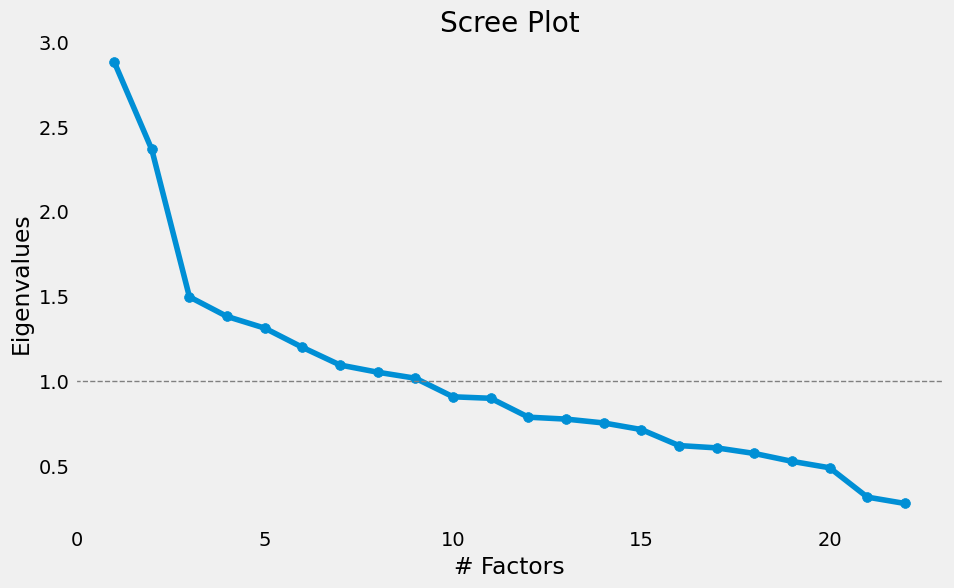

In [26]:
n_columns = len(X.columns)
scree_plot(eigenvalues, n_columns=n_columns)

In [27]:
number_of_factors = sum(eigenvalues > 1)
factor_model = train_factor_model(X, number_of_factors, rotation="promax")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<ipython-input-22-7e5384260bf3>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + variables, fontsize=10)
<ipython-input-22-7e5384260bf3>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + factors, rotation="vertical", fontsize=10)


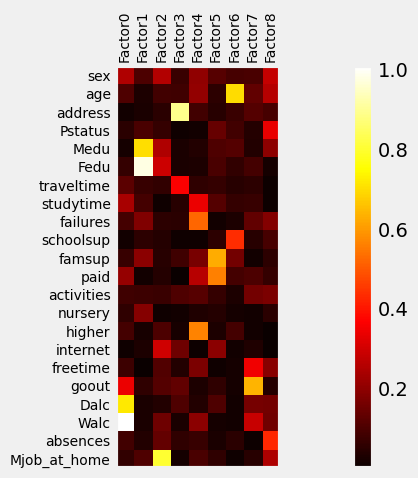

In [28]:
loadings = factor_model.loadings_
loadings_abs = np.abs(loadings)

columns = X.columns.tolist()
loadings_plot(loadings_abs, columns)

In [29]:
n_factors = loadings.shape[1]
factors_list = ["Factor{}".format(index) for index in range(n_factors)]
factors = {}.fromkeys(factors_list, None)
for key in factors:
  factors[key] = []

argsmax = loadings_abs.argmax(axis=1)
for argmax, column in zip(argsmax, columns):
  factors[factors_list[argmax]].append(column)

In [30]:
factors

{'Factor0': ['Dalc', 'Walc'],
 'Factor1': ['Medu', 'Fedu', 'nursery'],
 'Factor2': ['internet', 'Mjob_at_home'],
 'Factor3': ['address', 'traveltime'],
 'Factor4': ['studytime', 'failures', 'higher'],
 'Factor5': ['famsup', 'paid'],
 'Factor6': ['age', 'schoolsup'],
 'Factor7': ['freetime', 'goout'],
 'Factor8': ['sex', 'Pstatus', 'activities', 'absences']}

 Факторы можно описать так:

Фактор 0: Потребление алкоголя

Фактор 1: Образование родителей

Фактор 2: Инфраструктура дома

Фактор 3: Расстояние до школы

Фактор 4: Целеустремленность

Фактор 5: Финансовые стимулы семьи к образованию

Фактор 6: Дополнительные занятия

Фактор 7: Общительность

Фактор 8: Внеклассные мероприятия и посещаемость

##  РСА

In [32]:
X = data.drop(labels=["G1", "G2", "G3"], axis=1)
y = data[["G3"]]

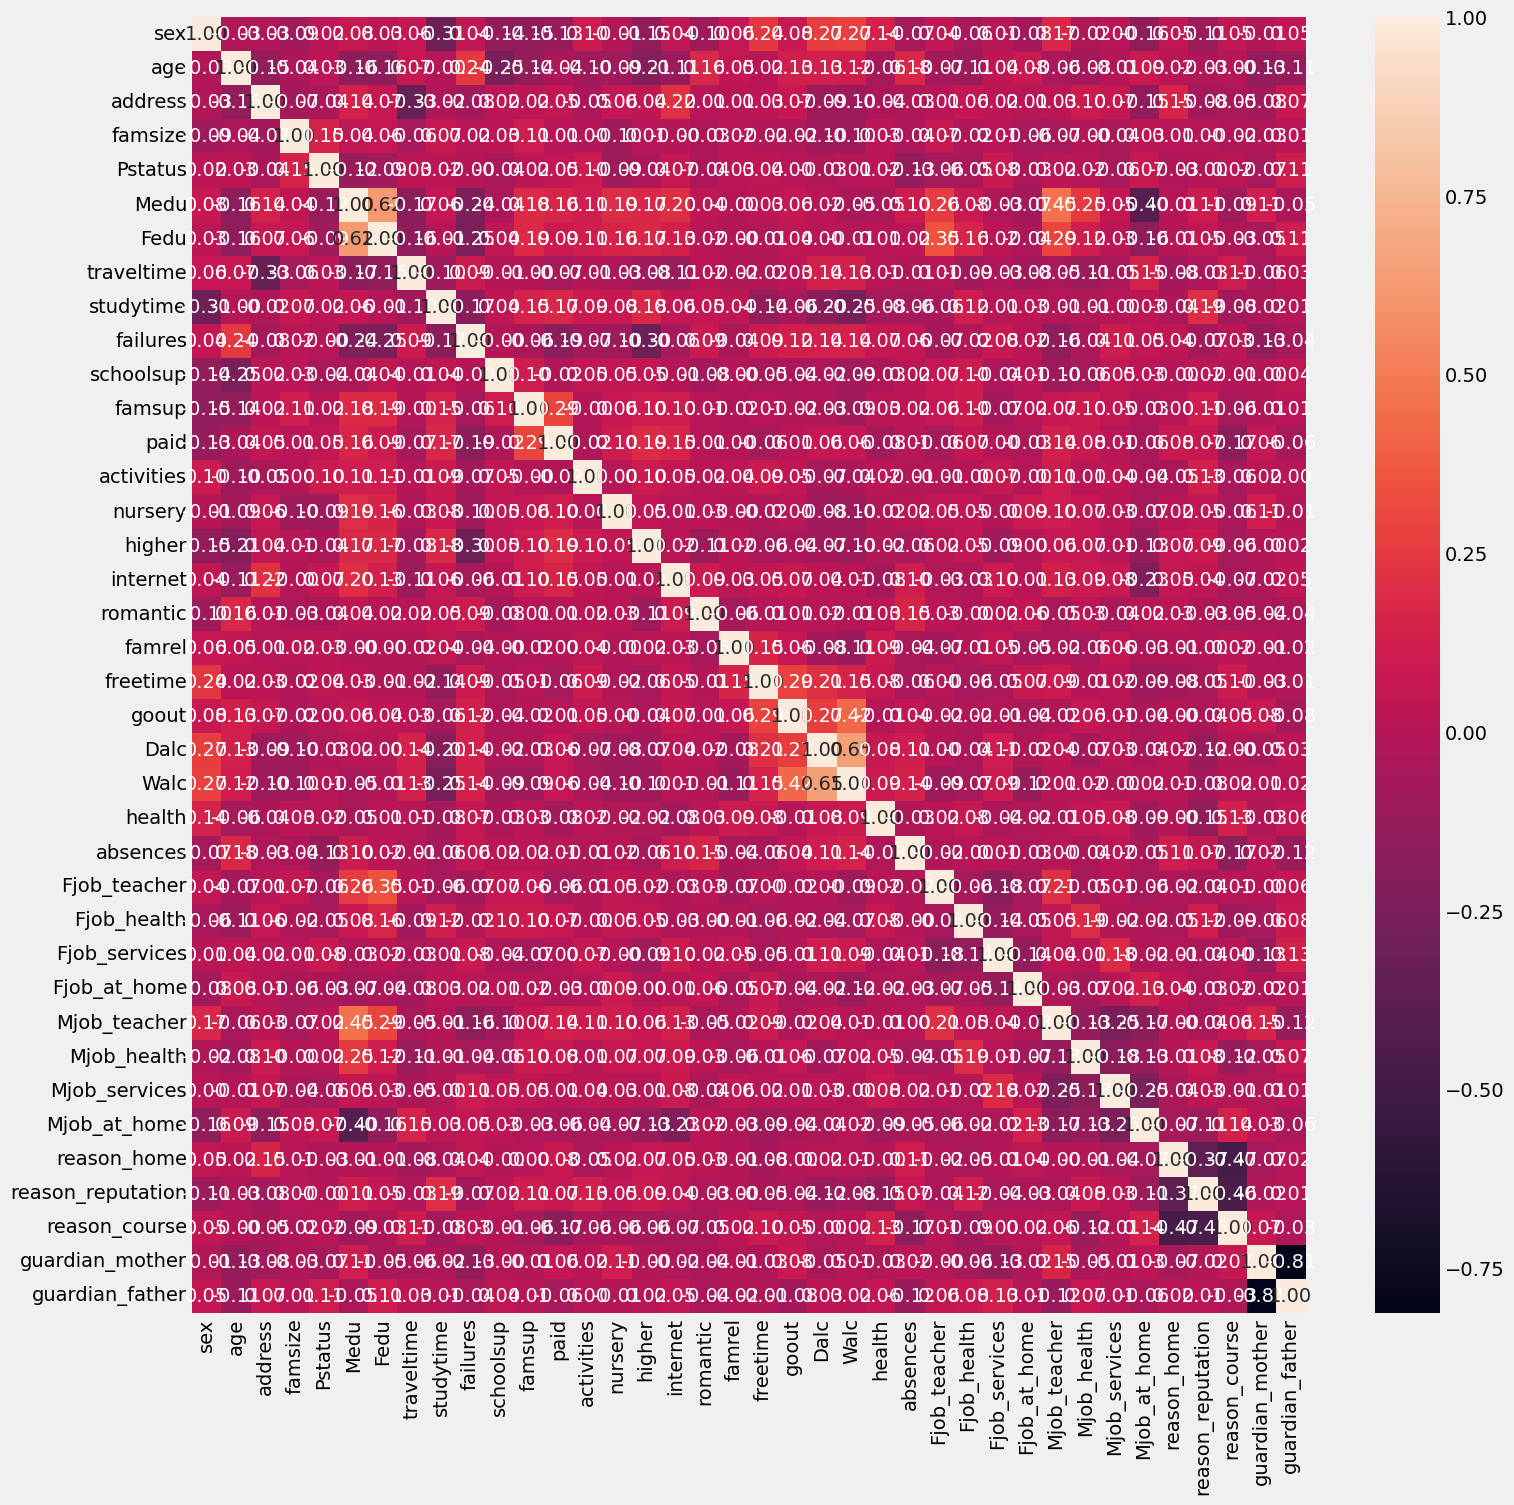

In [34]:
plt.figure(figsize=(16,16))
sns.heatmap(X.corr(), annot=True,fmt=".2f")
plt.show()

In [35]:
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [38]:
pca = PCA()
pca_values = pca.fit_transform(X_scaled)

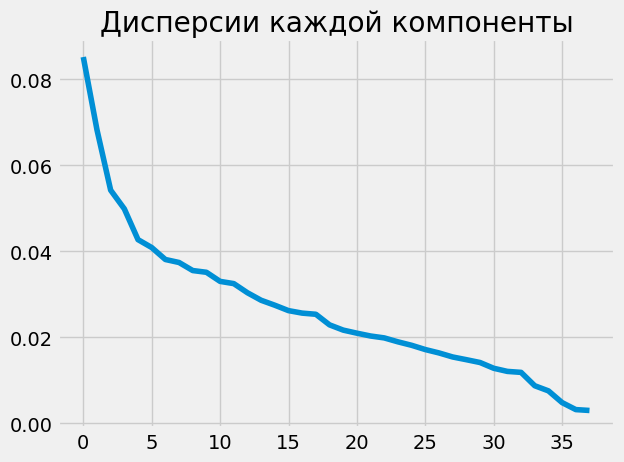

In [40]:
var = pca.explained_variance_ratio_
plt.plot(var)
plt.title('Дисперсии каждой компоненты')
# Дисперсии каждой компоненты
plt.show()

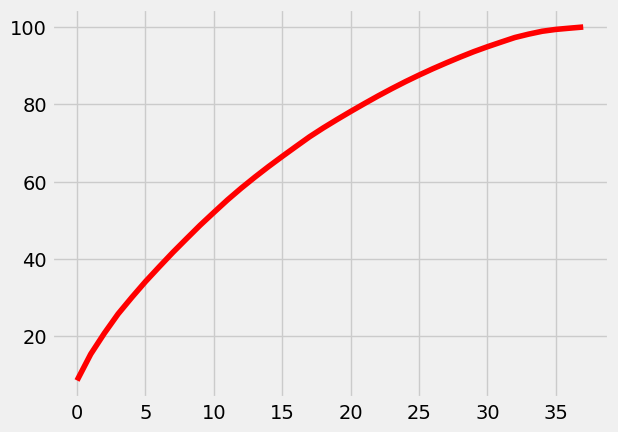

array([  8.52,  15.34,  20.76,  25.74,  30.01,  34.1 ,  37.91,  41.65,
        45.2 ,  48.71,  52.01,  55.26,  58.29,  61.15,  63.89,  66.51,
        69.07,  71.6 ,  73.89,  76.05,  78.14,  80.17,  82.15,  84.04,
        85.85,  87.56,  89.19,  90.73,  92.21,  93.62,  94.9 ,  96.1 ,
        97.28,  98.15,  98.9 ,  99.38,  99.7 , 100.  ])

In [41]:
var1 = np.cumsum(np.round(var,decimals = 4)*100)
# Объясненная дисперсия
plt.plot(var1,color="red")
plt.show()
var1

In [43]:
new_df = pd.DataFrame(pca_values[:,0:5])

In [45]:
X_train, X_test, y_train,y_test =train_test_split(X,y, test_size=0.2,random_state=42)
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [46]:
pca= PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [47]:
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.0759493670886076
[[1 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 2 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 2 1 0 0 0 0 0 0 0 0]
 [5 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 4 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 1 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]]
              precision    recall  f1-score   support

           0       0.08      0.20      0.12         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         5
          10       0.12      0.27      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
X_train, X_test, y_train,y_test =train_test_split(X,y, test_size=0.2,random_state=42)
model = LogisticRegression()
model.fit(X_train,y_train)
predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.16455696202531644
[[4 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 3 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 0 0 0 2 0 0 0 0]
 [0 0 0 0 2 0 0 1 1 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 2 4 2 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 1 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 2 0 2 1 0 0 0 0]
 [1 0 0 0 0 1 1 1 1 0 3 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]]
              precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.17      0.17      0.17         6
           9       0.00      0.00      0.00         5
          10       0.18      0.18      0

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre